In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import random
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.path import Path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import networkx as nx

<h1>
    <b>
        Parameter UWSN
    </b>
</h1>

In [2]:
D = 1e3
P = 1e3
L = 1e3
r = 250
d_max = 1200
BS = [P/2, L/2, 0]

N = 48
f = 4e4
pH = 7.7         
sh = 0.55
T = 4     
S = 34     
w = 5  
k = 2
spreading_factor = 1.5
m = 10

kc = 25
kd = 2500
kt = kd + N
beta = 0.8
data_rate = 500 # bps
t_transmission =  ((kd * 8)/data_rate) + ((kc * 8)/data_rate) + (((kc + N) * 8)/data_rate)
initial_energy = 1
E_elec = 50 * 1e-9
P_tx = 1e-3
p = 0.05

<h1>
    <b>
        Underwater environment
    </b>
</h1>

In [3]:
def vibrationFrequencies(show_info = False):
    f1 = 0.78 * np.sqrt(S/35) * np.exp(T/26)
    f2 = 42 * np.exp(T/17)

    if show_info: 
        print(f"F1 : {f1:.2f} | f2 : {f2:.2f}")

    return f1, f2

f1, f2 = vibrationFrequencies(show_info = False)
def attenuationConstant(D, show_info = False):
    D_km = D/1e3
    f1_kHz = f1/1e3
    f2_kHz = f2/1e3
    f_kHz = f/1e3

    term1 = 0.106 * (f1_kHz * f_kHz**2) / (f1_kHz**2 + f_kHz**2) * np.exp((pH - S) / 0.56)
    term2 = 0.52 * (1 + (T / 43)) * (S / 35) * (f2_kHz * f_kHz**2) / (f2_kHz**2 + f_kHz**2) * np.exp(-D_km / 0.56)
    term3 = 4.9e-4 * f2 * np.exp(T / 27 + D_km / 17)
    attenuation = term1 + term2 + term3
    if show_info: 
        print(f"attenuation constant: {attenuation:.2f}")

    return attenuation

def attenuation_dB(distance, show_info = False):
    distance = distance/1e3
    att = k * np.log10(distance) + distance * attenuationConstant(show_info = True) * 1e-3
    if show_info:   
        print(f"Attenuation at distance ({distance:.2f} m) : {att:.2f} dB")
    return att

def attenuation(D, distance, show_info = False):
    distance = distance/1e3
    att = (distance**spreading_factor) * (attenuationConstant(D, show_info = False)**distance)
    if show_info:   
        print(f"Attenuation at distance ({distance:.2f} m) | Att {att:.2f} | Att constant : {attenuationConstant(D, show_info = False)}")
        print(f"Attenuation at distance ({distance:.2f} m) : {att:.2f} dB")
    return att

def noise(show_info = False):
    f_khz = f / 1e3
    turbulence_noise    = 17 - 30 * np.log10(f_khz)
    ship_noise          = 40 + 20 * (sh - 0.5) + 26 * np.log10(f_khz) - 60 * np.log10(f_khz + 0.03)
    wind_noise          =  50 + 7.5 * np.sqrt(w) + 20 * np.log10(f_khz) - 40 * np.log10(f_khz + 0.4)
    thermal_noise       =  -15 + 20 * np.log10(f_khz)

    noise_total = turbulence_noise + ship_noise + wind_noise + thermal_noise

    if show_info:   
        turbulence_noise    = round(turbulence_noise    , 2)
        ship_noise          = round(ship_noise          , 2)
        wind_noise          = round(wind_noise          , 2)
        thermal_noise       = round(thermal_noise       , 2)
        noise_total         = round(noise_total       , 2)
        print(f"Noise total : {noise_total} | Thermal noise : {thermal_noise} | Ship noise : {ship_noise} | Wind noise : {wind_noise} | Turbulence noise : {turbulence_noise} | f : {f_khz} kHz")
    return noise_total

def underwater_speed(D, show_info = False):
    D_km = D/1e3
    v_uw = 1448.96 + 4.591 * T - 5.304e-2 * T**2 + 2.374 * T**3 + 1.340 * (S - 35) + \
           1.630e-2 * D_km + 1.675e-7 * D_km**2 - 1.025e-2 * T * (S - 35) - 7.139e-13 * D_km**3 * T
    
    if show_info:
        print(f"Underwater speed at D = {D:.2f} is : {v_uw:.2f} m/s")

    return v_uw

def ratio_delay(D, distance):
    v_uw = underwater_speed(D, show_info = False)
    t_uw = distance/v_uw
    a = t_uw/t_transmission
    # print(f"Ratio delay : {a:.2f} | T_tranmission : {t_transmission:.2f} | T_uw : {t_uw:.2f}")
    return a

def throughput(a):
    numerator = kc * np.exp(-a * kc)
    denominator = kc * (1 + 2 * a) + np.exp(-a * kc)
    rho = numerator / denominator
    # print(f"Throughput : {rho:.2f} | numerator : {numerator:.2f} | denominator : {denominator:.2f}")
    return rho


<h1>
    <b>
        Arsitektur UWSN
    </b>
</h1>

In [4]:

class Node:
    def __init__(self, x, y, z, id):
        self.x = x
        self.y = y
        self.z = z
        self.energy = initial_energy
        self.nϵG = False
        self.alive = True
        self.CH = False
        self.which_cluster = 0
        self.eligible_round = 0
        self.cluster_class = 0
        self.id = id

    def distance(self, other_node):
        return np.sqrt((self.x - other_node.x)**2 + (self.y - other_node.y)**2 + (self.z - other_node.z)**2)

    def reset(self):
        self.CH = False
        self.which_cluster = 0

    def advertisement(self, count_cluster, eligible_round):
        self.CH = True
        self.nϵG = False
        self.eligible_round = eligible_round
        self.which_cluster = count_cluster
    
    def energySelection(self, d_CH_BS, p):
        # If node selected as a CH
        a = ratio_delay(self.z, d_CH_BS)
        rho = throughput(a)
        first_term = (kc / rho) * (E_elec + P_tx * attenuation(self.z, d_CH_BS, show_info = False))
        second_term = (p * (N - 1) / rho) * (beta * E_elec * kc)
        third_term = E_elec * kt
        E_Selection = first_term + second_term + third_term
        return E_Selection
    
    def energyIdle(self):
        return beta * E_elec * kc

    def energyAdvertisement(self):
        # Broadcasting to all nodes in the range of d_max, occurs only for CH
        return kc * (E_elec + P_tx * attenuation(self.z, d_max, show_info = False))
    
    def energyJoin(self, p):
        # Node receive the broadcasting message and decide whether want to join as a associated node for CH i-th
        return p * N * kc * E_elec

    def energy_contention_TDMA_CH(self, Nc):
        return kc * Nc * E_elec + kt * (E_elec + P_tx * attenuation(self.z, d_max, show_info = False))
    
    def energy_contention_TDMA_Node(self, d_CH_Node):
        a = ratio_delay(self.z, d_CH_Node)
        rho = throughput(a)
        energy = (kc / rho) * (E_elec + P_tx * attenuation(self.z, d_CH_Node, show_info = False)) + ((N-1)/ rho) * kc * beta * E_elec + kt * E_elec
        return energy
    
    def energyFrame_CH(self, Nc, d_CH_BS):
        return m * Nc * kd * E_elec * beta * kd * E_elec + kd * (E_elec + P_tx * attenuation(self.z, d_CH_BS, show_info = False))
    
    def energyFrame_Node(self, d_CH_Node):
        return m * kd * E_elec * (E_elec + P_tx * attenuation(self.z, d_CH_Node, show_info = False))
    
    

def triangulation3D(show_info=False):
    d = r*np.sqrt(3)
    N_l = np.ceil((((P-d)/d) + 1))
    N_h = np.ceil(((2*np.sqrt(3)*L-6*d+4*np.sqrt(3)*r)/(3*d)) + 1)
    N_total = N_h * N_l
    dy = np.power(d, 2) - np.power(d/2, 2)
    dy = np.sqrt(dy)
    dh = ((np.sqrt(3)/2) * d) - r
    dl = d/2
    numLayer = -int(D/r)
    
    sensor_pos = {'x' : [], 'y':[], 'z':[]}
    sensor_coverage = []

    for z in range(numLayer, 0, 1):
         for x in range(0, int(N_l)):
            for y in range(0, int(N_h)):
                if y % 2 != 0:
                    # Odd
                    x_p = (d * x) 
                    y_p = dy * y
                    z_p = z * r
                    sensor_pos['x'].append(x_p)
                    sensor_pos['y'].append(y_p)
                    sensor_pos['z'].append(z_p)
                    sensor_coverage.append((x_p, y_p))
                else:
                    x_p = (d * x) + (d/2)
                    y_p = dy * y
                    z_p = z * r
                    sensor_pos['x'].append(x_p)
                    sensor_pos['y'].append(y_p)
                    sensor_pos['z'].append(z_p)
                    sensor_coverage.append((x_p, y_p))

    if show_info: 
        print(f"N_i : {N_l} | N_h : {N_h} | N_total : {N_total * -numLayer:.2f} | Num layer : {-numLayer} | d/r : {d/r:.2f} | r : {r:.2f} | d : {d:.2f} | dy : {dy:.2f} | dl : {dl:.2f} | dh : {dh:.2f}")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(sensor_pos['x'], sensor_pos['y'], sensor_pos['z'], marker="o",color='r', edgecolors='k')
        ax.scatter(BS[0], BS[1], BS[2], marker="s",color='b', edgecolors='k')
 
        fig, ax = plt.subplots()
        ax.yaxis.set_major_locator(MultipleLocator(int(P//5)))
        ax.yaxis.set_major_formatter('{x:.0f}')
        ax.yaxis.set_minor_locator(MultipleLocator(int(P//10)))
        ax.xaxis.set_major_locator(MultipleLocator(int(L//5)))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(int(L//10)))
        ax.scatter(sensor_pos['x'], sensor_pos['y'], color='r', edgecolors=None, facecolors='None')
        verts = [
        (0., 0.),  # left, bottom
        (0., P),  # left, top
        (L, P),  # right, top
        (L, 0.),  # right, bottom
        (0., 0.),  # ignored
        ]

        codes = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY,
        ]

        path = Path(verts, codes)

        rect = patches.PathPatch(path, facecolor='none', lw=0.5, linestyle='--')
        ax.add_patch(rect)
        for cov in sensor_coverage:
            circle = plt.Circle(cov, r, color='k', fill=False, linewidth=0.5, linestyle='--')
            ax.add_patch(circle)
        ax.set_xlabel('Length (m)')
        ax.set_ylabel('Width (m)')
        plt.axis('equal')
    return sensor_pos



<h1>
    <b>
        Network environment model
    </b>
</h1>

In [5]:
class multiHop(object):
    def __init__(self,graph):
        self.graph = graph
        self.adjacent_mat = nx.adjacency_matrix(graph).todense()
        self.num_nodes = len(self.adjacent_mat)
        self.adjacent_mat = nx.adjacency_matrix(graph, nodelist=range(self.num_nodes)).toarray()#:D
        # print(f"\n Adjacent Matrix \n{self.adjacent_mat}\n")

    def q_learning(self,start_state=0, aim_state = 10, num_epoch=200, gamma=0.8, epsilon=0.05, alpha=0.1):

        len_of_paths = []
        rewards = self.rewardMapping(start_state, aim_state)
        # print(f"\n Reward \n{rewards}\n")


        q_table = np.zeros((self.num_nodes, self.num_nodes))  # num_states * num_actions
        td = []

        for episode in range(1, num_epoch + 1):
            #print(f"========================================================================== Episode : {episode} =========================================================================")
            current_state = start_state
            path = [current_state]
            len_of_path = 0
            while True:
                next_state = self.epsilon_greedy(current_state, q_table, start_state, epsilon=epsilon)
                s_next_next = self.epsilon_greedy(next_state, q_table, start_state, epsilon=epsilon)  # epsilon<0, greedy policy
                # update q_table
                reward = rewards[current_state][next_state]
                delta = reward + gamma * q_table[next_state, s_next_next] - q_table[current_state, next_state]

                q_table[current_state, next_state] = q_table[current_state, next_state] + alpha * delta
                # update current state
                current_state = next_state
                len_of_path += -reward
                path.append(current_state)


                td.append(delta)
                if current_state == aim_state:
                    break
            len_of_paths.append(len_of_path)

        return path, td

    def epsilon_greedy(self,s_curr, q, start_state, epsilon):
        potential_next_states = np.where(np.array(self.adjacent_mat[s_curr]) <= d_max)[0]
        potential_next_states = potential_next_states[potential_next_states != start_state]
        if random.random() > epsilon:
            q_of_next_states = q[s_curr][potential_next_states]
            s_next = potential_next_states[np.argmax(q_of_next_states)]
        else:
            s_next = random.choice(potential_next_states)
        return s_next

    def rewardMapping(self, start_state, aim_state):
        r = self.adjacent_mat.copy()
        r[:, aim_state] = 1000  # Reward for reaching aim_state
        r[aim_state, :] = 1000  # Reward for starting from aim_state
        for i in range(len(r)):
            for j in range(len(r)):
                if i == j:
                    r[i][j] = -99999  # Penalty for remaining in the same state
                if r[i][j] > d_max:
                    r[i][j] = -1000  # Strong penalty for distances exceeding d_max
        return r

class networkEnvironment:
    def __init__(self, nodes, mode, showInfo, showPlotIteration):
        self.nodes = nodes 
        self.mode = mode
        self.alive_data = []
        self.energy_data = []
        self.node_failure = []
        self.centroids = np.array([[P//2, L//2, 0]])
        self.showInfo = showInfo
        self.showPlotIteration = showPlotIteration
        self.multihop_path = []
    
    def showResult(self, hop):
        fig, ax = plt.subplots(1, 3, figsize=(20,5))
        rounds = np.array([i for i in range(0, len(self.alive_data))])
        self.alive_data = np.array(self.alive_data)
        self.energy_data = np.array(self.energy_data)
        self.node_failure = np.array(self.node_failure)

        ax[0].plot(rounds, self.alive_data, color='k')
        ax[0].scatter(rounds[::hop], self.alive_data[::hop], marker='o', edgecolor='k', color='r')
        ax[0].set_ylabel("Node Alive")
        ax[0].set_xlabel("Round")

        ax[1].plot(rounds, self.energy_data, color='k')
        ax[1].scatter(rounds[::hop], self.energy_data[::hop], marker='o', edgecolor='k', color='r')
        ax[1].set_ylabel("Energy Consumed")
        ax[1].set_xlabel("Round")

        ax[2].plot(rounds[::hop], self.node_failure[::hop], color='k')
        ax[2].scatter(rounds[::hop], self.node_failure[::hop], marker='o', edgecolor='k', color='r')
        ax[2].set_ylabel("Node Failure")
        ax[2].set_xlabel("Round")

        # ax[0].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.alive_data))/20))
        # ax[0].yaxis.set_major_formatter('{x:.2f}')
        # ax[0].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.alive_data))/30))
        # ax[0].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        # ax[0].xaxis.set_major_formatter('{x:.2f}')
        # ax[0].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))
        
        # ax[1].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.energy_data))/20))
        # ax[1].yaxis.set_major_formatter('{x:.2f}')
        # ax[1].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.energy_data))/30))
        # ax[1].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        # ax[1].xaxis.set_major_formatter('{x:.2f}')
        # ax[1].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))

        # ax[2].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.node_failure))/10))
        # ax[2].yaxis.set_major_formatter('{x:.2f}')
        # ax[2].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.node_failure))/20))
        # ax[2].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        # ax[2].xaxis.set_major_formatter('{x:.2f}')
        # ax[2].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))


    def showNetwork(self, simulation_round):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        normal_nodes = {'x':[], 'y':[], 'z':[]}
        orphan_nodes = {'x':[], 'y':[], 'z':[]}
        CH_nodes = {'x':[], 'y':[], 'z':[]}
        BS_node = {'x':[], 'y':[], 'z':[]}
        dead_nodes = {'x':[], 'y':[], 'z':[]}
        all_nodes = {'x':[], 'y':[], 'z':[]}
        energy = 0
        node_alive = 0
        count_CH = 0

        for node in self.nodes:
            normal_node_status = ((node.id != 0) and (node.CH == False) and (node.which_cluster != 0) and (node.energy > 0))
            orphan_node_status = ((node.id != 0) and (node.CH == False) and (node.which_cluster == 0) and (node.energy > 0))
            CH_node_status = ((node.id != 0) and (node.CH == True) and (node.alive) and (node.energy > 0))
            dead_node_status = ((node.id != 0) and (node.energy < 0) and (node.alive != True))
            
            if normal_node_status:
                normal_nodes['x'].append(node.x)
                normal_nodes['y'].append(node.y)
                normal_nodes['z'].append(node.z)
            if orphan_node_status:
                orphan_nodes['x'].append(node.x)
                orphan_nodes['y'].append(node.y)
                orphan_nodes['z'].append(node.z)
            if CH_node_status:
                CH_nodes['x'].append(node.x)
                CH_nodes['y'].append(node.y)
                CH_nodes['z'].append(node.z)
                count_CH += 1
            if node.id == 0:
                BS_node['x'].append(node.x)
                BS_node['y'].append(node.y)
                BS_node['z'].append(node.z)
            if dead_node_status:
                dead_nodes['x'].append(node.x)
                dead_nodes['y'].append(node.y)
                dead_nodes['z'].append(node.z)
            if node.alive:
                energy += node.energy
                node_alive += 1



        energy = np.round(energy, 2)
        ax.scatter(normal_nodes['x']    , normal_nodes['y']       , normal_nodes['z']   , marker="o",color='purple' , edgecolors='k', label = "Node")
        ax.scatter(orphan_nodes['x']    , orphan_nodes['y']       , orphan_nodes['z']   , marker="o",color='c'      , edgecolors='k', label = "Orphan Node")
        ax.scatter(CH_nodes['x']        , CH_nodes['y']           , CH_nodes['z']       , marker="o",color="lime"   , edgecolors='k', label = "Cluster Head")
        ax.scatter(dead_nodes['x']      , dead_nodes['y']         , dead_nodes['z']     , marker="x",color='r'      , label="Dead Node")
        ax.scatter(BS_node['x']         , BS_node['y']            , BS_node['z']        , marker="s",color="b"      , edgecolors='k', label="Base station", s=50)

        font = {
                'color':  'black',
                'weight': 'bold'
                }

        print(f"Paths : {self.multihop_path}")
        if self.mode == "Q-Learning":
            for index_path in range(len(self.multihop_path)-1):
                print(f"{index_path} | Path : {len(self.multihop_path)} | Node : {len(self.nodes)}")
                start_x = self.nodes[self.multihop_path[index_path]].x
                start_y = self.nodes[self.multihop_path[index_path]].y
                start_z = self.nodes[self.multihop_path[index_path]].z
                end_x = self.nodes[self.multihop_path[index_path+1]].x
                end_y = self.nodes[self.multihop_path[index_path+1]].y
                end_z = self.nodes[self.multihop_path[index_path+1]].z

                # Compute the direction (vector) from start to end
                dx = end_x - start_x
                dy = end_y - start_y
                dz = end_z - start_z
                ax.quiver(start_x, start_y, start_z, dx, dy, dz, scale=1, width=0.005)
                
        elif self.mode == "DECKS":
            ax.scatter(self.centroids[:,0]  , self.centroids[:,1]     , self.centroids[:,2] , marker="o",color="y"      , edgecolors='k', label="Centroid")

        ax.set_title(f'Round : {simulation_round+1} | E : {energy} | CH : {count_CH}', fontdict=font)
        ax.set_xlabel('Length (m)')
        ax.set_ylabel('Width (m)')
        ax.set_zlabel('Depth (m)')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5, markerscale=1, fontsize=10)
        plt.tight_layout()
        plt.show()

    def multiHopRouting(self, node):
        # Creatubg ab Adjacency Matrix for Q-Learning
        status = (
                (node.energy > 0) and 
                (node.alive == True)
            )
        G = nx.Graph()
        a = {"original":[],"connected":[],"weight":[]}
        for nodeA in self.nodes:
            for nodeB in self.nodes:
                if ((nodeA.id != nodeB.id) and (status)) :
                    distances = self.euclidean_distance(np.array([nodeA.x, nodeA.y, nodeA.z]), np.array([nodeB.x, nodeB.y, nodeB.z]))
                    G.add_edge(nodeA.id, nodeB.id, weight=distances)
                    a["original"].append(nodeA.id)
                    a["connected"].append(nodeB.id)
                    a["weight"].append(distances)
        print(G)
        Q_learning = multiHop(G)
        paths, _ = Q_learning.q_learning(start_state=node.id, aim_state = 0, num_epoch=10000, gamma=0.01, epsilon=0.01, alpha=0.1)
        print(f"Node : {node.id} => Paths : {paths}")
        return paths
    
    def euclidean_distance(self, nodeA, nodeB):
        return np.sqrt(np.sum((nodeA - nodeB)**2))
        
    def Nc(self, which_cluster):
        count = 0
        for node in self.nodes:
            if node.which_cluster == which_cluster:
                count += 1
        return count
    
    def LEACH(self, round_number):
        for node in self.nodes:
            d_CH_BS = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array(BS))
            status = (
                (node.energy > 0) and 
                (node.alive == True) and 
                (node.eligible_round == 0) and
                (d_CH_BS < d_max)
            )
            threshold = random.uniform(0, 1) <= p/(1-p * (round_number % (1/p)))
            if ((status) and (threshold)):
                node.CH = True
                node.which_cluster = node.id
                node.eligible_round = 1/p
                
    
    def CH_selection(self, round_number):
        for node in self.nodes:
            node.reset()
            
       
        self.LEACH(round_number)
        
        CHs = [node for node in self.nodes if node.CH]
        for node in self.nodes:
            status = ((node.energy > 0) and (node.alive == True) and (node.id != 0) and (node.CH != True))
            if len(CHs):
                distances = [[], []]
                if status:
                    for CH in CHs:
                        Ch_coor = [CH.x, CH.y, CH.z]
                        distances[0].append(
                            self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array(Ch_coor))
                        )
                        distances[1].append(CH.which_cluster)
                    if distances[0][np.argmin(distances[0])] > d_max:
                        node.which_cluster = 0
                    else:
                        node.which_cluster = distances[1][np.argmin(distances[0])]
            if len(CHs) <= 0:
                # Jika tidak ada yang terpilih sebagai CH, maka node akan diam
                if node.id != 0:
                    node.which_cluster = 0

        if round_number % self.showPlotIteration == 0:
            self.showNetwork(round_number)
            
    def SetupPhase(self, simulation_round):
        # CH Selection and Advertisement Energy Dissipation and Creating TDMA Schedule
        # Node Join Energy Dissipation and join TDMA Schedule
        self.CH_selection(simulation_round)
        CHs = [node for node in self.nodes if node.CH]
        for node in self.nodes:
            status = (
                (node.energy > 0) and 
                (node.alive == True) and 
                (node.id != 0) and 
                (node.which_cluster != 0)
            )
            if status:
                if node.CH:
                    Nc = self.Nc(node.which_cluster)
                    d_CH_BS = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array(BS))
                    energy_dissipated = node.energyAdvertisement() + node.energySelection(d_CH_BS, len(CHs)/N) + node.energy_contention_TDMA_CH(Nc)
                    node.energy = node.energy - energy_dissipated
                else:
                    for CH in CHs:
                        if node.which_cluster == CH.which_cluster :
                            d_CH_Node = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array([CH.x, CH.y, CH.z]))
                            energy_dissipated = node.energy_contention_TDMA_Node(d_CH_Node) + node.energyJoin(len(CHs)/N)
                            node.energy = node.energy - energy_dissipated
            
            if ((node.energy > 0) and (node.which_cluster == 0)):
                # If node is not in cluster, it become idle
                node.energy -= node.energyIdle()
                
            if node.energy < 0:
                if self.showInfo:
                    print(f"\tNode dead found during Setup phase at round - {simulation_round} \nNode id-{node.id} | E : {node.energy} | CH : {node.CH} | Cluster : {node.which_cluster}")
                node.alive = False
    
    def SteadyStatePhase(self):
        CHs = []
        energy_total = 0
        node_alive = 0
        node_failure = 0

        for node in self.nodes:
            status = (
                (node.energy > 0) and 
                (node.alive == True) and 
                (node.id != 0) and 
                (node.which_cluster != 0)
            )
            if status:
                if node.CH:
                    CHs.append(node)
        
        # Transmission process
        for node in self.nodes:
            if ((node.energy > 0) and (node.alive == True) and(node.id != 0) and (node.which_cluster != 0)):
                if node.CH == True:
                    Nc = self.Nc(node.which_cluster)
                    d_CH_BS = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array(BS))
                    node.energy = node.energy - node.energyFrame_CH(Nc, d_CH_BS)
                else:
                    for CH in CHs:
                        if node.which_cluster == CH.which_cluster :
                            d_CH_Node = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array([CH.x, CH.y, CH.z]))
                            node.energy = node.energy - node.energyFrame_Node(d_CH_Node)

            if ((node.energy > 0) and (node.alive == True) and(node.id != 0) and (node.which_cluster == 0)):
                if self.mode != "Q-Learning":
                    node_failure += 1
                    node.energy -= node.energyIdle()
                else:
                    self.multihop_path = self.multiHopRouting(node)

            node.eligible_round -= 1
            if node.eligible_round < 0:
                node.eligible_round = 0

            if node.energy < 0:
                node.alive = False
            
            if node.alive:
                node_alive += 1
                energy_total += node.energy
    

        self.node_failure.append(node_failure)
        self.alive_data.append(node_alive)
        self.energy_data.append(energy_total)

    def startSimulation(self, rounds):
        #self.showNetwork(0)
        for simulation_round in range(0, rounds+1):
            self.SetupPhase(simulation_round)
            self.SteadyStatePhase()
        self.showResult(self.showPlotIteration)

        return self.alive_data, self.energy_data, self.node_failure
                    

In [6]:
def createNetworks():
    sensor_pos = triangulation3D(show_info=False)
    nodes = []
    nodes.append(Node(BS[0], BS[1], BS[2], 0))
    for i in range(0, len(sensor_pos['x'])):
        nodes.append(
            Node(sensor_pos['x'][i], sensor_pos['y'][i],  sensor_pos['z'][i], i + 1)
        )
        # print(f"id : {i + 1}")

    return nodes

Paths : []


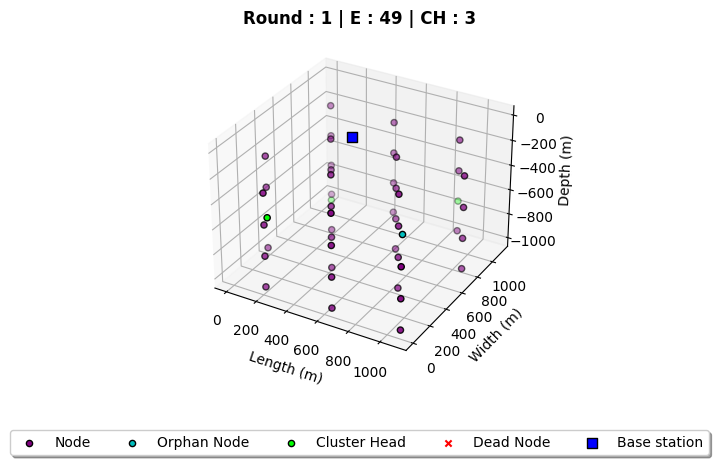

Paths : []


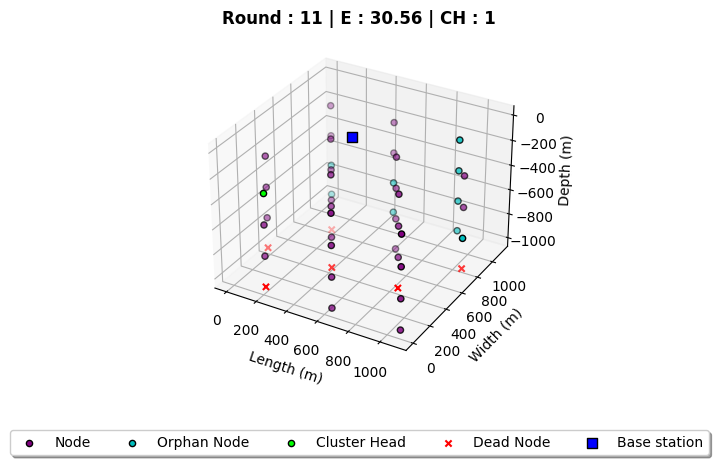

Paths : []


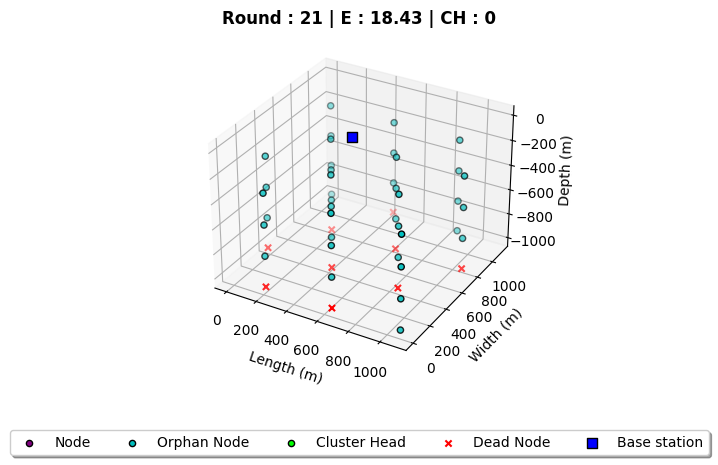

Paths : []


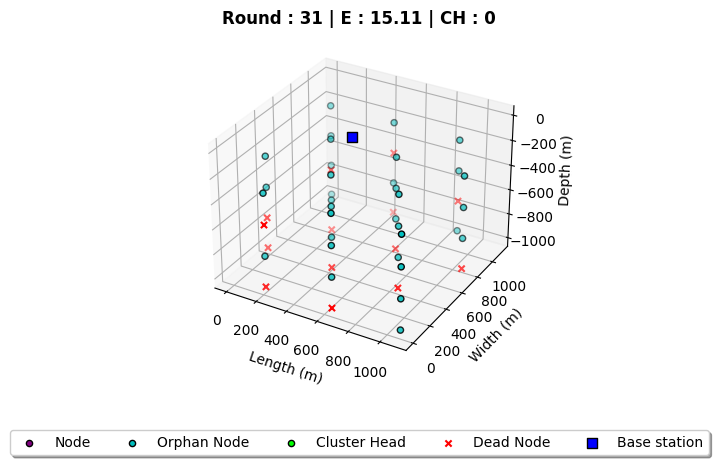

Paths : []


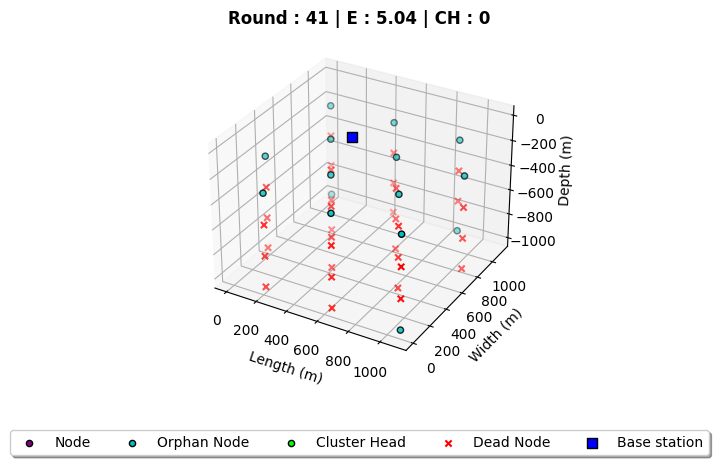

Paths : []


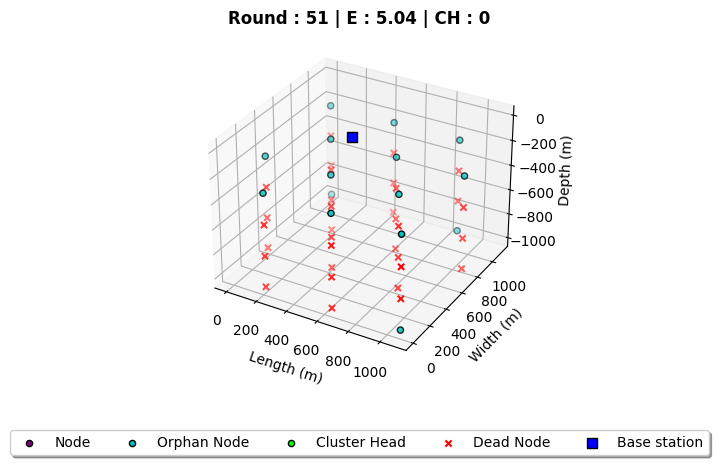

Paths : []


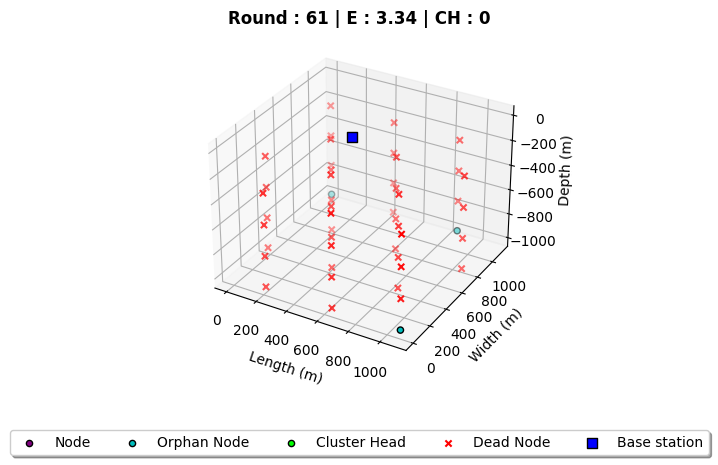

Paths : []


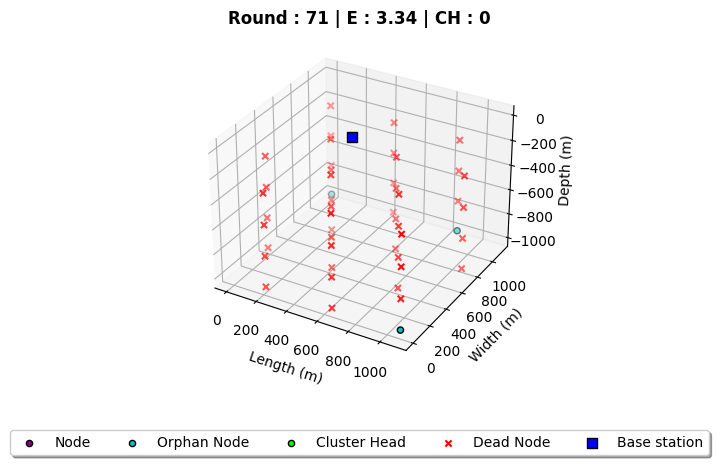

Paths : []


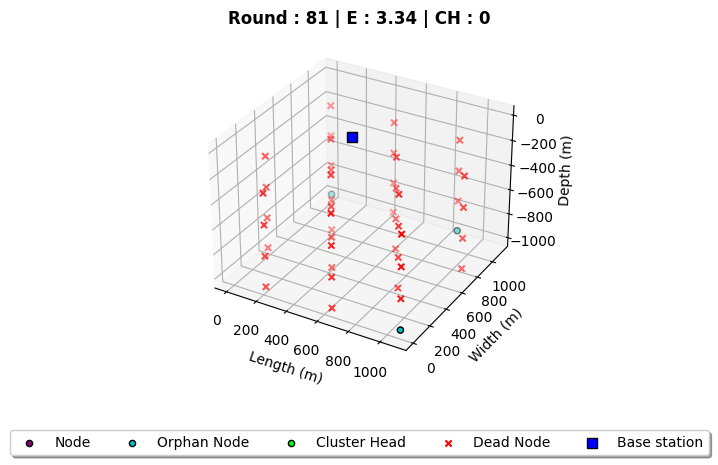

Paths : []


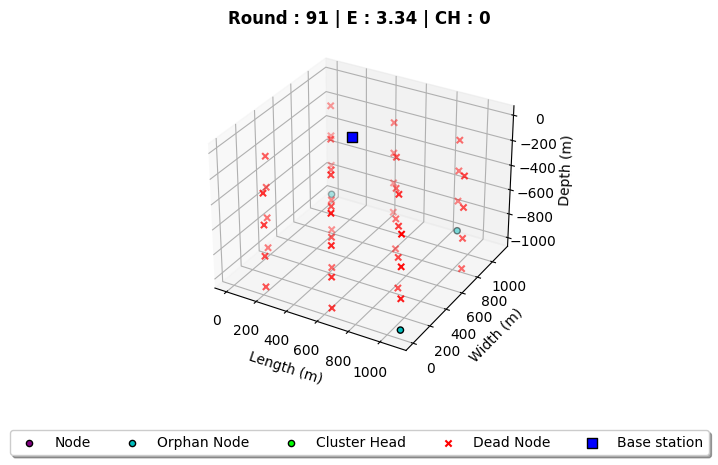

Paths : []


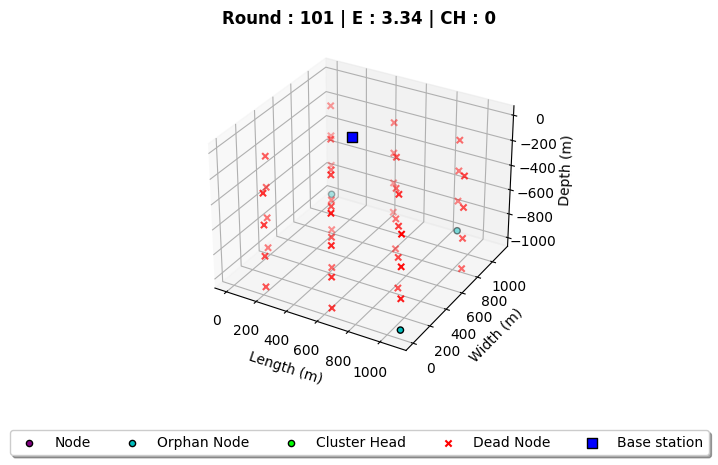

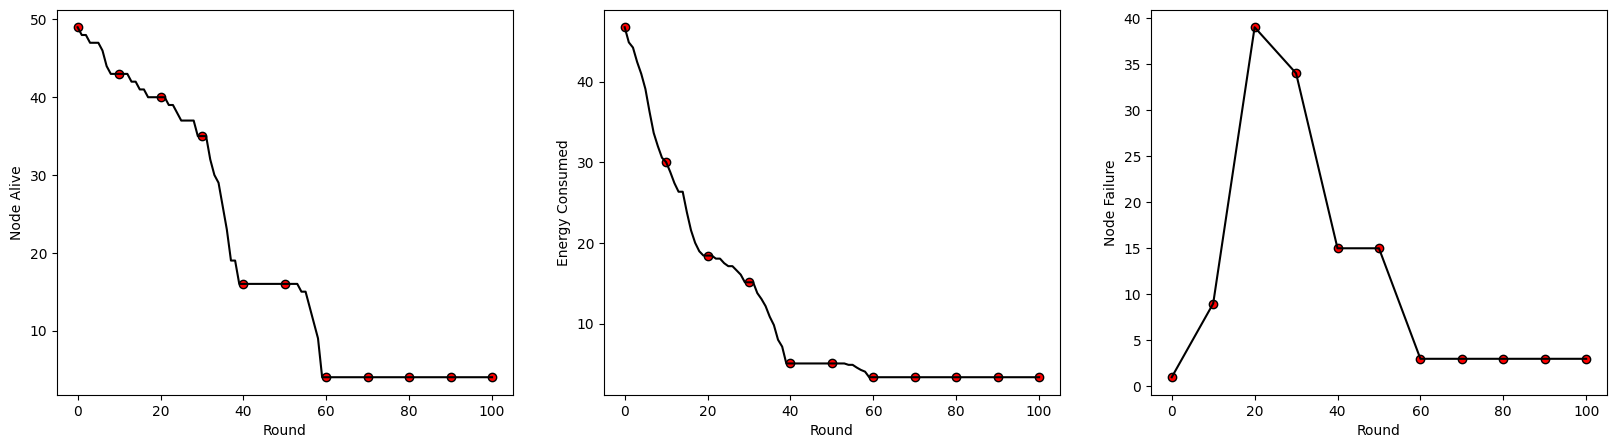

In [7]:
node_LEACH    = createNetworks()
LEACH = networkEnvironment(node_LEACH, "LEACH", False, 10)
LEACH_aliveNode, LEACH_EnergyNode, LEACH_NodeFailure = LEACH.startSimulation(100)

Text(0.5, 0, '$Depth (m)$')

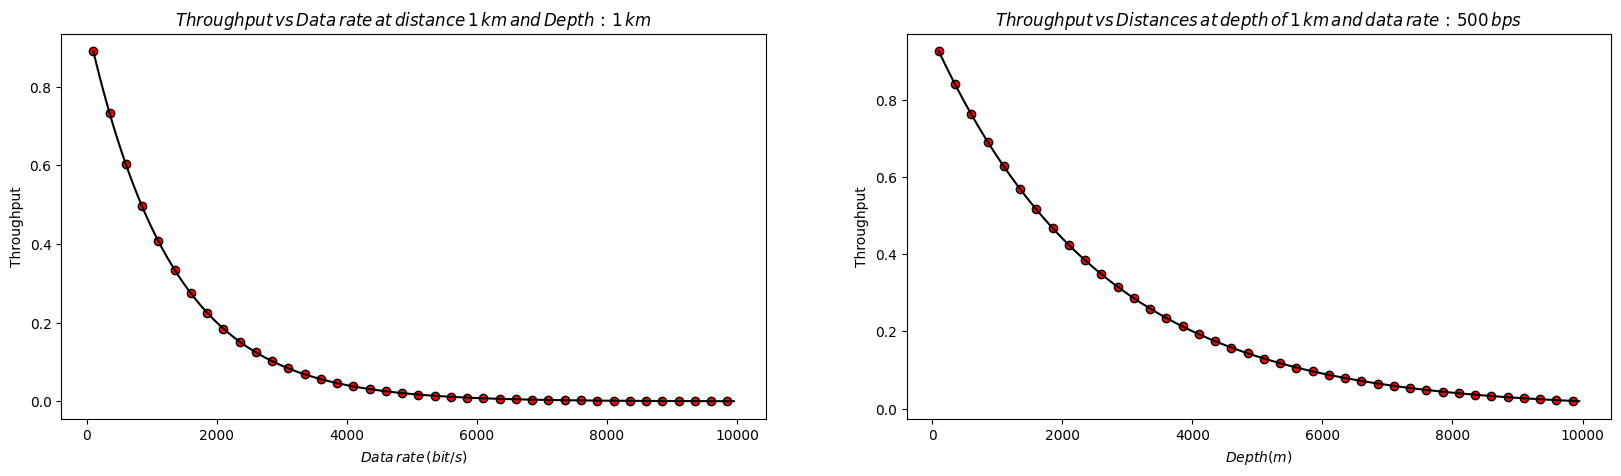

In [12]:
BPS = [i for i in range(100, 10000, 50)]
DEPTH = [i for i in range(100, 10000, 50)]

throughput_data_BPS = []
for i in BPS:
    t_transmission =  ((kd * 8)/i) + ((kc * 8)/i) + (((kc + N) * 8)/i)
    a = ratio_delay(1000, 1000)
    throughput_data_BPS.append(throughput(a))

throughput_data_depth = []
for i in DEPTH:
    t_transmission =  ((kd * 8)/data_rate) + ((kc * 8)/data_rate) + (((kc + N) * 8)/data_rate)
    a = ratio_delay(1000, i)
    throughput_data_depth.append(throughput(a))

fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(BPS, throughput_data_BPS, color='k')
ax[0].scatter(BPS[::5], throughput_data_BPS[::5], marker='o', edgecolor='k', color='r')
ax[0].set_title(r'$Throughput\,vs\,Data \,rate\,at\,distance \,1 \,km \,and \,Depth \,: \,1 \,km$')
ax[0].set_ylabel(r'Throughput')
ax[0].set_xlabel(r'$Data \,rate \,(bit/s)$')

ax[1].plot(BPS, throughput_data_depth, color='k')
ax[1].scatter(BPS[::5], throughput_data_depth[::5], marker='o', edgecolor='k', color='r')

ax[1].set_title(r'$Throughput\,vs\,Distances\,at\,depth \,of \,1 \,km \,and \,data \,rate \,: \,500 \,bps$')
ax[1].set_ylabel(r'Throughput')
ax[1].set_xlabel(r'$Depth (m)$')

In [9]:
throughput_data_depth

[0.6520340522392806,
 0.6520341805149753,
 0.6520343087906971,
 0.6520344370664461,
 0.6520345653422228,
 0.652034693618026,
 0.6520348218938569,
 0.6520349501697147,
 0.6520350784455999,
 0.6520352067215122,
 0.6520353349974518,
 0.6520354632734184,
 0.6520355915494126,
 0.6520357198254337,
 0.6520358481014821,
 0.6520359763775576,
 0.6520361046536605,
 0.6520362329297903,
 0.6520363612059477,
 0.652036489482132,
 0.6520366177583438,
 0.6520367460345825,
 0.6520368743108484,
 0.6520370025871416,
 0.6520371308634622,
 0.6520372591398098,
 0.6520373874161846,
 0.6520375156925864,
 0.6520376439690158,
 0.6520377722454721,
 0.6520379005219558,
 0.6520380287984665,
 0.6520381570750046,
 0.6520382853515697,
 0.6520384136281621,
 0.6520385419047816,
 0.6520386701814286,
 0.6520387984581023,
 0.6520389267348037,
 0.652039055011532,
 0.6520391832882874,
 0.6520393115650703,
 0.6520394398418802,
 0.6520395681187172,
 0.6520396963955815,
 0.652039824672473,
 0.6520399529493918,
 0.65204008122633